<a href="https://colab.research.google.com/github/danielegenta/Progetto-MLDL/blob/master/main_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install requirements**

In [1]:
"""!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'"""

"!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'"

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Retrieving dataset CIFAR1000**<br>
The CIFAR-100 dataset consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. There are 500 training images and 100 testing images per class.
The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
Here is an example of classes in the CIFAR-100:<br>
**Superclass**	
- aquatic mammals	

**Classes**
- beaver, dolphin, otter, seal, whale

In [3]:
DATA_DIR = 'DATA' # here the dataset will be downloaded

# Clone github repository with dataset handler
!rm -r Cifar100/
!rm -r $DATA_DIR
!mkdir "DATA"
if not os.path.isdir('./Cifar100'):
  !git clone https://github.com/danielegenta/Progetto-MLDL.git
  !mv 'Progetto-MLDL' 'Cifar100'
  !rm -r Cifar100/Theoretical-Sources
  !rm -rf Cifar100/ProjectMLDL.ipynb

rm: cannot remove 'Cifar100/': No such file or directory
rm: cannot remove 'DATA': No such file or directory
Cloning into 'Progetto-MLDL'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 1873 (delta 71), reused 103 (delta 37), pack-reused 1732
Receiving objects: 100% (1873/1873), 11.98 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (1126/1126), done.


In [4]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2020-06-10 06:38:33--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  32.8MB/s    in 5.5s    

2020-06-10 06:38:39 (29.3 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists


**Set arguments** - 
src: iCaRL section 4 

In [5]:
from Cifar100 import utils
dictHyperparams = utils.getHyperparams()
print(dictHyperparams)

DEVICE = dictHyperparams["DEVICE"] # 'cuda' or 'cpu'
NUM_CLASSES = dictHyperparams["NUM_CLASSES"] 

BATCH_SIZE = dictHyperparams["BATCH_SIZE"]     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = dictHyperparams["LR"]          # The initial Learning Rate
MOMENTUM = dictHyperparams["MOMENTUM"]       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = dictHyperparams["WEIGHT_DECAY"] # Regularization, you can keep this at the default

NUM_EPOCHS = dictHyperparams["NUM_EPOCHS"]     # Total number of training epochs (iterations over dataset)
GAMMA = dictHyperparams["GAMMA"]         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = dictHyperparams["LOG_FREQUENCY"]
MILESTONES = dictHyperparams["MILESTONES"]
RANDOM_SEED = dictHyperparams["SEED"]

{'LR': 2, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 1e-05, 'NUM_EPOCHS': 70, 'MILESTONES': [49, 63], 'BATCH_SIZE': 128, 'DEVICE': 'cuda', 'GAMMA': 0.2, 'SEED': 42, 'LOG_FREQUENCY': 10, 'NUM_CLASSES': 100}


**Define data preprocessing**<br>
This transformations are applied to each images when they're loaded into the datasets

In [0]:
train_transform, eval_transform = utils.getTransformations()

**Prepare dataset**<br>
Loading of the train and test split as it comes with CIFAR100. <br>
The trainset consists in 50k images, while the test set len is 10k images.

In [7]:
from Cifar100.Dataset.cifar100 import CIFAR100

# Import dataset
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# check if datasets have been correctly loaded
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [0]:
from Cifar100.reverse_index import ReverseIndex

def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

**Build dataset splits and reverse index**<br>
Here the train dataset is split into train and validation set, following the proportion XX/YY.<br>
Furthermore train, test and validation sets are splitted into 10 groups containing 10 classes each (the split is coherent among the different sets).<br>

In [0]:
# performing the train/val split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)

# performing the test split (coherent with train/val)
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

**Prepare dataloaders**

In [10]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

# [ DEBUG ]
# test to check classes in different dataset
# (coherent split)
# RESULT: OK
"""dict_train={}
for img_train in train_subsets[0]:
  if img_train[1] not in dict_train:
    dict_train[img_train[1]]=1
  else:
    dict_train[img_train[1]]+=1
dict_val={}
for img_val in val_subsets[0]:
  if img_val[1] not in dict_val:
    dict_val[img_val[1]]=1
  else:
    dict_val[img_val[1]]+=1
dict_test={}
for img_test in test_subsets[0]:
  if img_test[1] not in dict_test:
    dict_test[img_test[1]]=1
  else:
    dict_test[img_test[1]]+=1

print(sorted(dict_test.keys()))
print(sorted(dict_test.keys()))
print(sorted(dict_test.keys()))"""

'dict_train={}\nfor img_train in train_subsets[0]:\n  if img_train[1] not in dict_train:\n    dict_train[img_train[1]]=1\n  else:\n    dict_train[img_train[1]]+=1\ndict_val={}\nfor img_val in val_subsets[0]:\n  if img_val[1] not in dict_val:\n    dict_val[img_val[1]]=1\n  else:\n    dict_val[img_val[1]]+=1\ndict_test={}\nfor img_test in test_subsets[0]:\n  if img_test[1] not in dict_test:\n    dict_test[img_test[1]]=1\n  else:\n    dict_test[img_test[1]]+=1\n\nprint(sorted(dict_test.keys()))\nprint(sorted(dict_test.keys()))\nprint(sorted(dict_test.keys()))'

**Utility functions to use our customized resnet model**

In [0]:
from Cifar100.resnet import resnet32

def addOutputs(net, num):
    net.addOutputNodes(num)

def getResNet32():
    net = resnet32()
    # net.fc = nn.Linear(net.fc.in_features, output_size) # embedded in the class

    criterion = utils.getLossCriterion()
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = utils.getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return net, criterion, optimizer, scheduler

def addOutputs(net, num):
    net.addOutputNodes(num)

def getNet():
    return getResNet32()

def getSchedulerOptimizer(net):
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = utils.getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return optimizer, scheduler

**Basic train, test and validation functions**

In [0]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, num_epochs=NUM_EPOCHS):     
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime
    
    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:
            # Bring data over the device of choice
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            labels_enc = utils._one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad() # Zero-ing the gradients

            outputs = net(images)

            loss = utils.computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # preds = getLabels(outputs_labels_mapping, preds)
            # print(preds)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    utils.getLossCriterion()

    # confusion matrix
    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        #labels = outputs_labels_mapping.getNodes(labels)
        labels_enc = utils._one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        outputs = net(images)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = utils.computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        # preds = getLabels(outputs_labels_mapping, preds)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    # Calculate Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

**Joint Training**<br>
In this section joint training is perfomed.<br>
The train of the network is split into 10 stages, one for each subset classes.
At each step, the network is trained on the images corresponding to the current 10 classes and all the data already seen in the previous steps.
The joint training score, evaluated in terms of accuracy on the test set, gives us an UB for the next methodologies examined in this project (iCaRL, LWF).<br>
Operatively, what happens is a very slow training and, furthermore, we break the assumption of not needing the previous batches of data at each step. 

In [0]:
####
## Joint training
####
# Joins 2+ subsets into a new Subset (joint training)
def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)

def jointTraining(getNet, addOutputs, train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getNet()

    train_set = None
    test_set = None
    first_pass = True

    current_train_num = 0
    total_trains = len(train_subsets)
    joint_start = time.time()

    print('\n\nJoint-training start\n\n')
    all_accuracies=[]
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
        phase_start = time.time()
        print('\n\nJoint phase {}/{}\n\n'.format(current_train_num+1, total_trains))
        current_train_num += 1

        #num_classes_per_group = 10
        num_classes_seen = current_train_num*10

        # Builds growing train and test set. The new sets include data from previous class groups and current class group
        if train_set is None:
            train_set = train_subset
        else:
            train_set = joinSubsets(train_dataset, [train_set, train_subset])
        if test_set is None:
            test_set = test_subset
        else:
            test_set = joinSubsets(test_dataset, [test_set, test_subset])

        if first_pass:
            first_pass = False
        else:
            addOutputs(net, 10)

        # Trains model on previous and current class groups
        optimizer, scheduler = getSchedulerOptimizer(net)
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen)

        # Validate model on current class group
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
        v_acc, v_loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
        print('\nValidation accuracy: {} - Validation loss: {}\n'.format(v_acc, v_loss))

        # Test the model on previous and current class groups
        test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
        acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
        all_accuracies.append(acc_all)
        print('\nTest accuracy: {}\n'.format(acc_all))

        print('\n\nPhase completed in {} seconds\n\n'.format(time.time() - phase_start))
    
    print('\n\n Joint-training finished in {} seconds'.format(time.time() - joint_start))
    return net, all_accuracies, all_preds_cm, all_labels_cm

**Test joint training**<br>
What we expect is a test accuracy higher of what we'll be able to achieve using iCaRL, LWF.



Joint-training start




Joint phase 1/10


Starting epoch 1/70, LR = [2]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Streaming output truncated to the last 5000 lines.
Train step - Step 4410, Loss 0.01757151633501053
Train step - Step 4420, Loss 0.01914128288626671
Train step - Step 4430, Loss 0.021019693464040756
Train step - Step 4440, Loss 0.019819555804133415
Train step - Step 4450, Loss 0.024213099852204323
Train step - Step 4460, Loss 0.022808922454714775
Train step - Step 4470, Loss 0.015928272157907486
Train step - Step 4480, Loss 0.019707078114151955
Train step - Step 4490, Loss 0.021032137796282768
Train step - Step 4500, Loss 0.019204210489988327
Train step - Step 4510, Loss 0.018045928329229355
Train step - Step 4520, Loss 0.017775069922208786
Train step - Step 4530, Loss 0.02240082435309887
Train epoch - Accuracy: 0.682334455667789 Loss: 0.019390462218176502 Corrects: 30398
Starting epoch 14/70, LR = [2]
Train step - Step 4540, Loss 0.02151624858379364
Train step - Step 4550, Loss 0.024143997579813004
Train step - Step 4560, Loss 0.021988140419125557
Train step - Step 4570, Loss 0.019359

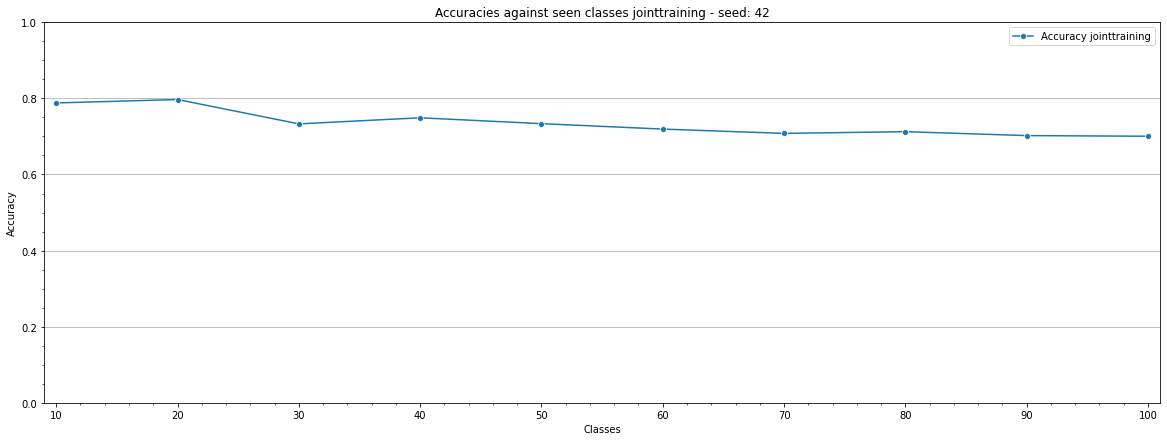

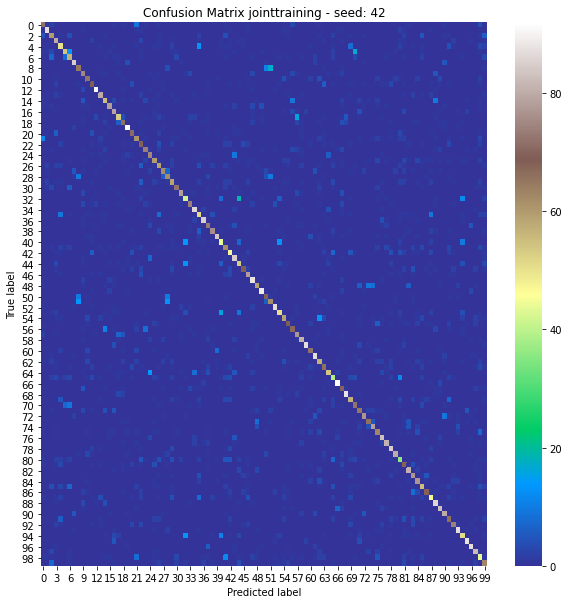

NameError: ignored

In [14]:
# Test Joint training

net, all_accuracies, all_preds_cm, all_labels_cm = jointTraining(getNet, addOutputs, train_subsets, val_subsets, test_subsets)

# output Joint training
method = "jointtraining"
print("metrics jointtraining for seed {}".format(RANDOM_SEED))

data_plot_line=[]
for id in range(0,10):
    data_plot_line.append(((id+1)*10,all_accuracies[id]))

#plt.figure(figsize=(20,7))
#accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
#ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
#plt.title("Single Group Sequential Accuracy")
#plt.show()

# plot accuracy trend
utils.plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
utils.plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
utils.writeMetrics(method, RANDOM_SEED, all_accuracies, confusionMatrixData)

# [DEBUG]
#net, criterion, optimizer, scheduler = getResNet32()
#train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
#train(net, train_dataloader, criterion, optimizer, scheduler)

**Fine tuning (catastrophic forgetting)**<br>
In this section of the homework the aim is to demonstrate how, without ad-hoc methodologies, our CNN is unable to learn without dramatically forgetting what it has already been learnt.<br>
Operatively, what we do is to perform a training again divided into (ten) steps but without exploiting previous data as before (joint training).
What we should observe is a dramatic drop in the perfomances of the network.*italicized text*

In [0]:
### Fine tuning
def sequentialLearning(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1


    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    #confusion_matrix(all_labels_cm, all_preds_cm)

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

In [0]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearning(train_subsets, val_subsets, test_subsets)

GROUP:  1
Starting epoch 1/70, LR = [2]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.6901078820228577
Train step - Step 10, Loss 0.3247760236263275
Train step - Step 20, Loss 0.2987397015094757
Train step - Step 30, Loss 0.30344995856285095
Train epoch - Accuracy: 0.16121212121212122 Loss: 0.3912074251488002 Corrects: 798
Starting epoch 2/70, LR = [2]
Train step - Step 40, Loss 0.30295270681381226
Train step - Step 50, Loss 0.2963450849056244
Train step - Step 60, Loss 0.2957838475704193
Train step - Step 70, Loss 0.3007523715496063
Train epoch - Accuracy: 0.18484848484848485 Loss: 0.29860427785401394 Corrects: 915
Starting epoch 3/70, LR = [2]
Train step - Step 80, Loss 0.29217034578323364
Train step - Step 90, Loss 0.30655863881111145
Train step - Step 100, Loss 0.30829039216041565
Train step - Step 110, Loss 0.30797630548477173
Train epoch - Accuracy: 0.19494949494949496 Loss: 0.2986088549007069 Corrects: 965
Starting epoch 4/70, LR = [2]
Train step - Step 120, Loss 0.3140912652015686
Train step - Step 130, Loss 0.2932884097099304
Train s

**Results fine tuning (catastrophic learning)**<br>
What we expect is a dramatic drop in the perfomances with repsect to the Joint Training and the incapacity to learn new things without forgetting the old ones.

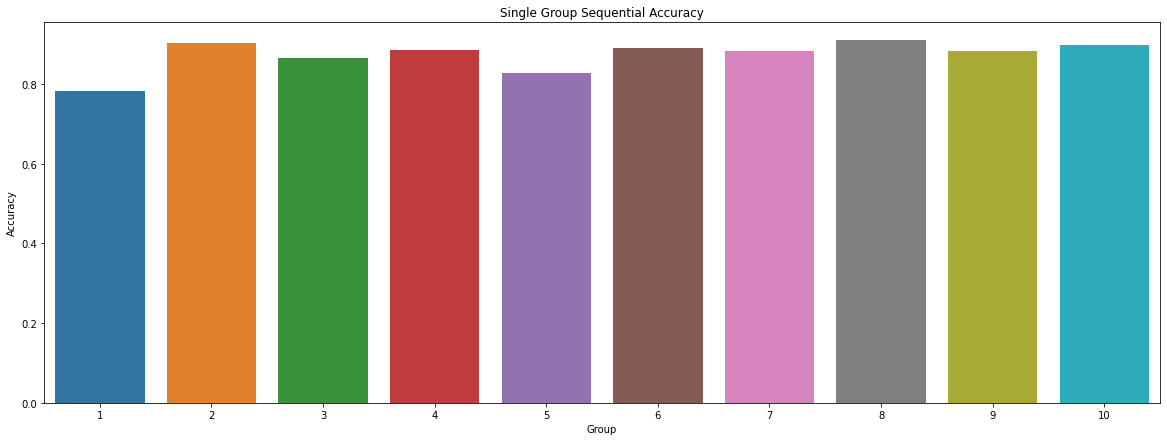

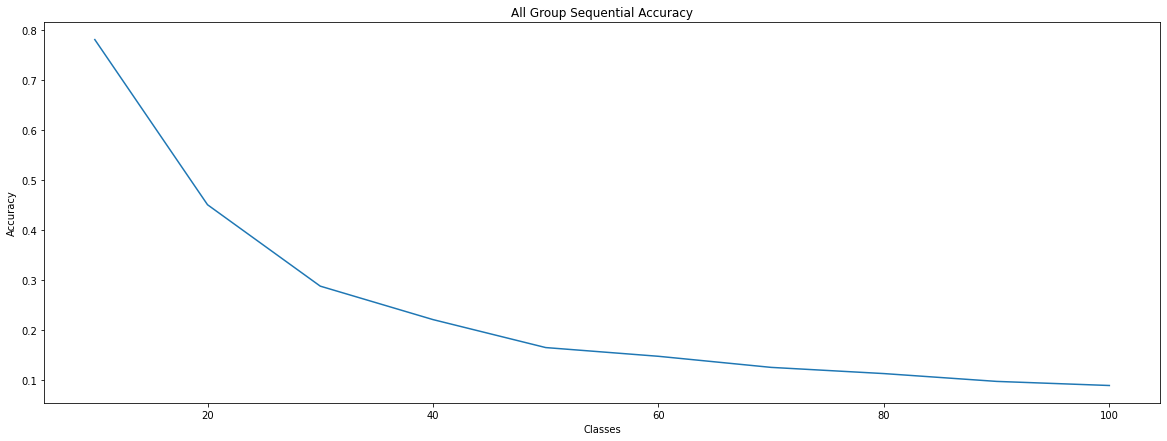

In [0]:
method = "finetuning"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
utils.plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
utils.plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
utils.writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [0]:
"""num_classes_seen = 100
dif_accuracies=printAccuracyDifference(net,old_accuracies, num_classes_seen)
dif_accuracies"""

[(1, 0.784, 0.0),
 (2, 0.902, 0.0),
 (3, 0.865, 0.0),
 (4, 0.904, 0.0),
 (5, 0.843, 0.0),
 (6, 0.891, 0.0),
 (7, 0.89, 0.0),
 (8, 0.918, 0.0),
 (9, 0.884, 0.0),
 (10, 0.888, 0.888)]